# Analysing Superconductivity Measurements
Group 4: Ryan E, Ryan S, Charlie, Lin

Demonstrator: Emma

In [94]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import os

In [90]:
filename = 'data/theta90/Measurement_3_0.50_Field_90_Angle.csv'

df = pd.read_csv(filename, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')
df

,current_A,voltage_uV,time_s
0,0.001374,-1.147232,0.000
1,0.001493,-1.155723,0.046
2,0.001440,-1.157938,0.092
3,0.001470,-1.177527,0.139
4,0.001357,-1.168936,0.185
...,...,...,...
1184,50.575273,46.828987,76.567
1185,50.605946,47.131116,76.612
1186,50.637175,47.440590,76.659
1187,50.743026,47.754784,76.706


Extracting metadata by reading the file - temperature, angle and magnetic field.

In [91]:
# Step 1: Open the file and read lines manually
f = open(filename)
text = f.readlines()

# Step 2: Extract metadata, ignoring blank lines
def extract_value(lines, key):
    """Helper function to extract the value for a given key."""
    for line in lines:
        if key in line:
            return float(line.split('\t')[1].strip())  # Extract the value after tab

temperature = extract_value(text, "Temperature (K)")
angle = extract_value(text, "Angle (deg.)")
field = extract_value(text, "field / T")
print(f'T={temperature}, Angle={angle}, Field={field}')

T=77.0, Angle=0.0, Field=0.5


Quick Plot of Voltage (uV) vs Current (A): 

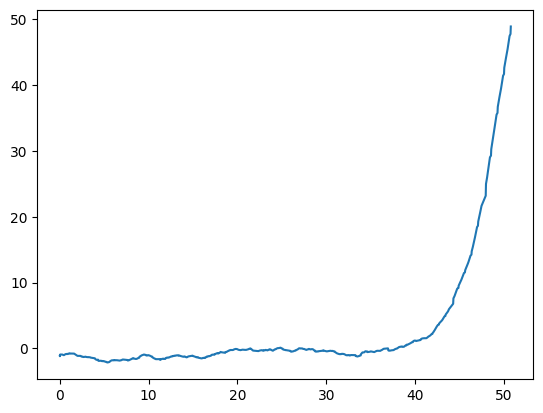

In [92]:
plt.plot(df['current_A'],df['voltage_uV'])

To find the critical current $I_C$, we read off the graph where we have an electric field E=100 uV/m. The distance between our voltage points on the sample is 0.8 cm. Therefore the voltage where this occurs is E*m = 100 uV/m * 0.008 m = 0.8 uV.

After speaking to demonstrator, we chose an electric field of 2000 uV/m instead which corresponds to a voltage V = 20 uV.

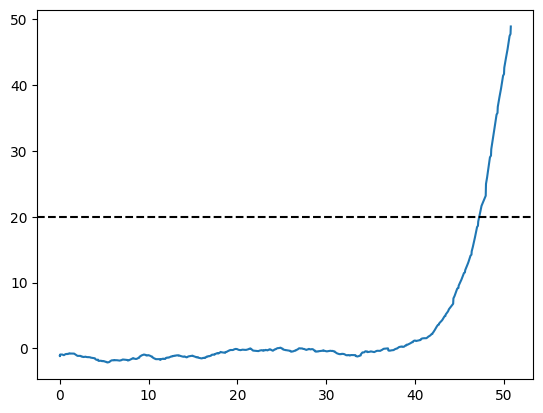

In [93]:
fig, ax = plt.subplots()
ax.plot(df['current_A'],df['voltage_uV'])
ax.axhline(20, c="black", ls="--")

In [7]:
(df['voltage_uV'] - 20).abs().idxmin()

793

In [8]:
I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

Now we have the code, we will now iterate through all the data files.

[]

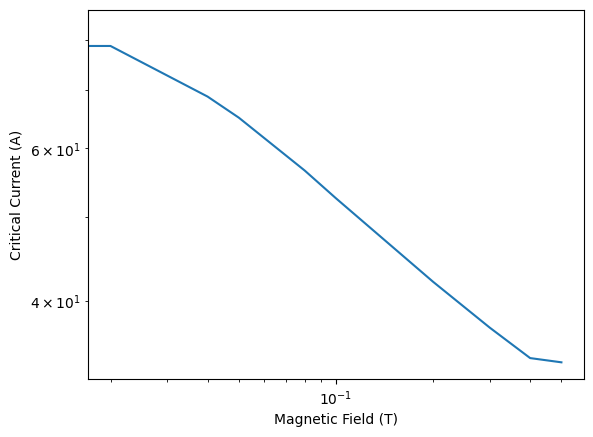

In [9]:
# Iterate through files in specified directory #
def Analyse_directory(directory):
    rows = []
    for filename in os.listdir(directory):
        try:
            file_string = os.path.join(directory, filename).replace('\\','/')   # example string: 'data/P1_B1_Idefault_Ndefault.mat'
            df = pd.read_csv(file_string, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')

        except:
            print(f"Error: Cannot load {file_string}.")

        # Extract metadata from filename
        filename_split = file_string.split("_")
        angle = float(filename_split[-2])
        field = float(filename_split[-4])

        # Find Critical Current (current value at voltage closest to 20 uV)
        I_c = df.loc[(df['voltage_uV'] - 20).abs().idxmin()]['current_A']

        # Append to our whole dataset
        row = [angle,field,I_c]
        rows.append(row)

    columns=['angle','field','I_c']
    df_Ic = pd.DataFrame(rows, columns=columns)
    return df_Ic

df_Ic_0 = Analyse_directory('data/theta0/')

fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'])
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
plt.loglog()

In [10]:
df_Ic_0 = Analyse_directory('data/theta0/')
df_Ic_45 = Analyse_directory('data/theta45/')
df_Ic_90 = Analyse_directory('data/theta90/')
df_Ic_135 = Analyse_directory('data/theta135/')


[]

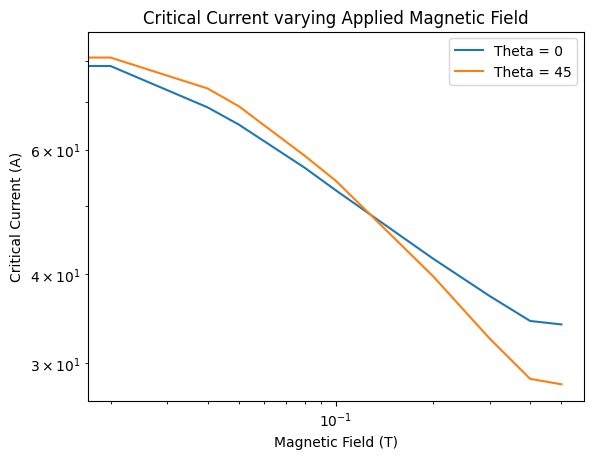

In [11]:
fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'], label="Theta = 0")
ax.plot(df_Ic_45['field'], df_Ic_45['I_c'], label="Theta = 45")
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
ax.set_title("Critical Current varying Applied Magnetic Field")
plt.legend()
plt.loglog()


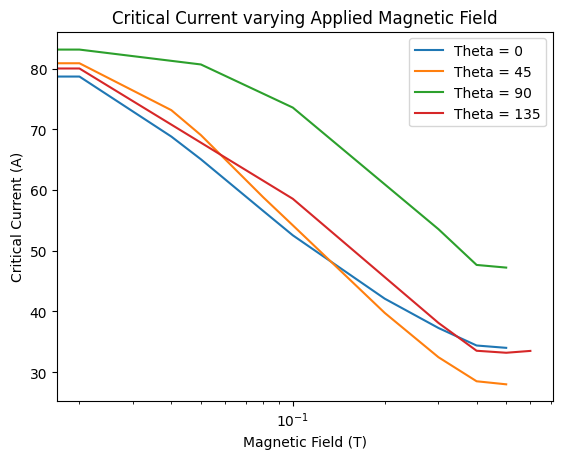

In [12]:
fig, ax = plt.subplots()
ax.plot(df_Ic_0['field'], df_Ic_0['I_c'], label="Theta = 0")
ax.plot(df_Ic_45['field'], df_Ic_45['I_c'], label="Theta = 45")
ax.plot(df_Ic_90['field'], df_Ic_90['I_c'], label="Theta = 90")
ax.plot(df_Ic_135['field'], df_Ic_135['I_c'], label="Theta = 135")
ax.set_xlabel("Magnetic Field (T)")
ax.set_ylabel("Critical Current (A)")
ax.set_title("Critical Current varying Applied Magnetic Field")
plt.xscale('log')
plt.legend()
# plt.loglog()


Instead of finding the critical current at E=2000 uV/m, we can curve fit the data to:

$E=E_C \left(\frac{I}{I_C}\right)^n$

multiply by distance between voltage probes on both sides:

$V=V_C \left(\frac{I}{I_C}\right)^n$

Because there's a linear increase before the critical current, we will first linear fit to the first half of the data. We subtract this linear fit from the data, and then fit to the power law above. 


In [96]:
def linear_fitting(xdata, ydata):
    """
    Linear fitting to input xdata and ydata
    
    Returns:
    --------
    m - gradient
    c - y-intercept
    """
    linear_fit = linregress(xdata, ydata)
    m = linear_fit[0]
    c = linear_fit[1]

    return m, c

def fit_function(x, *params):   # x is current I
    I_c, n = params 
    return 10 * (x/I_c)**n

def power_fitting(xdata, ydata):
    """
    Fits the function y=m*x + V_c * (x/I_c)*30

    arguments:
    ----------
    - xdata 
    - ydata
    
    returns:
    --------
    - I_c - critical current
    - n - exponent of (I/I_c)^n
    - popt - all parameters from scipy.optimize.curve_fit
    """

    # Initial Guesses
    guess = [1, 20]

    try:
        popt, pcov = curve_fit(fit_function, xdata, ydata, p0=guess, ) # can add maxfev=5000
    except RuntimeError as e:
        print('Fit did not converge:', e)
    # Print Parameters
    for i in range(len(popt)):
        print(f'Parameter {i}: {popt[i]:.5f}') # ± {np.sqrt(pcov[i][i]):.5f}

    I_c = popt[0]
    n = popt[1]

    return I_c, n, popt

Let's try fitting to one dataset first:

Parameter 0: 31.51944
Parameter 1: 9.53014
Critical Current = 31.519


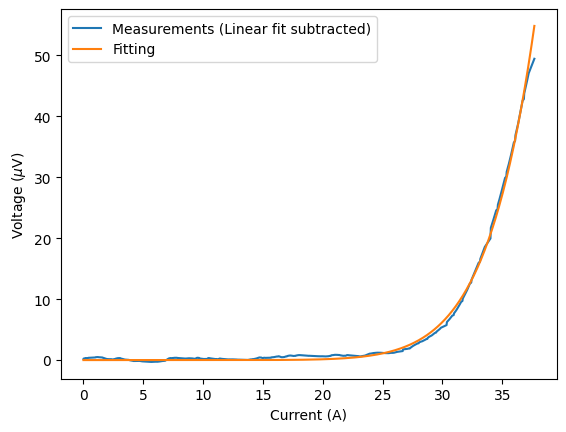

In [104]:
filename = 'data/theta0/Measurement_1_0.50_Field_0_Angle.csv'
df = pd.read_csv(filename, skiprows=11, names=['current_A','voltage_uV','time_s'], sep='\\s+')

# Linear Fitting to half the data
median_current = df['current_A'].median()
slope, intercept = linear_fitting(df['current_A'][df['current_A']<median_current], df['voltage_uV'][df['current_A']<median_current])
linear_yvalues = df['voltage_uV']*slope + intercept

xdata = df['current_A']
ydata = df['voltage_uV'] - linear_yvalues

x_extended = np.linspace(df['current_A'].min(), df['current_A'].max(), 500)
I_c, n, popt = power_fitting(xdata, ydata)
y_fit = fit_function(x_extended, *popt)

fig, ax = plt.subplots()
ax.plot(xdata, ydata, label='Measurements (Linear fit subtracted)')
ax.plot(x_extended, y_fit, label='Fitting')
ax.set_xlabel('Current (A)')
ax.set_ylabel('Voltage ($\\mu$V)')
plt.legend()
plt.plot()

print(f'Critical Current = {I_c:.3f}')
